In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from helper import *

In [6]:
# enter resolution of grid in meters
grid_resolution=1000
# add the file path to each species here
species_filepath_dict={
    'amphibians': "D:\hotspot mapping\Data\AMPHIBIANS\AMPHIBIANS\AMPHIBIANS.shp",
    'reptiles': "D:\hotspot mapping\Data\REPTILES\REPTILES\REPTILES.shp",
    'mammals': "D:\hotspot mapping\Data\MAMMALS\MAMMALS\MAMMALS.shp",
}

In [7]:
# get Costa Rica map and its bounds
cr_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')
cr_polygon=cr_map['geometry'].to_list()[0]

C:\Users\Jinze Wang\AppData\Local\Temp\ipykernel_10644\1117065986.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cr_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')


In [8]:
final_dict={}
# generate grid
grid = create_grid(resolution=grid_resolution, target_polygon=cr_polygon)
for species, file_path in species_filepath_dict.items():
    species_geo = filter_species(path= file_path, target_polygon=cr_polygon)
    species_count = count_species(species_geo, grid)
    # plot_abundance(species_count,species_name=species)
    final_dict['count_{}'.format(species)]=species_count
    # break
final_df = gpd.GeoDataFrame(final_dict)

C:\Users\Jinze Wang\AppData\Local\Temp\ipykernel_10644\1946085009.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cr_map=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')


Text(0.5, 1.0, 'Species Abundance in CR')

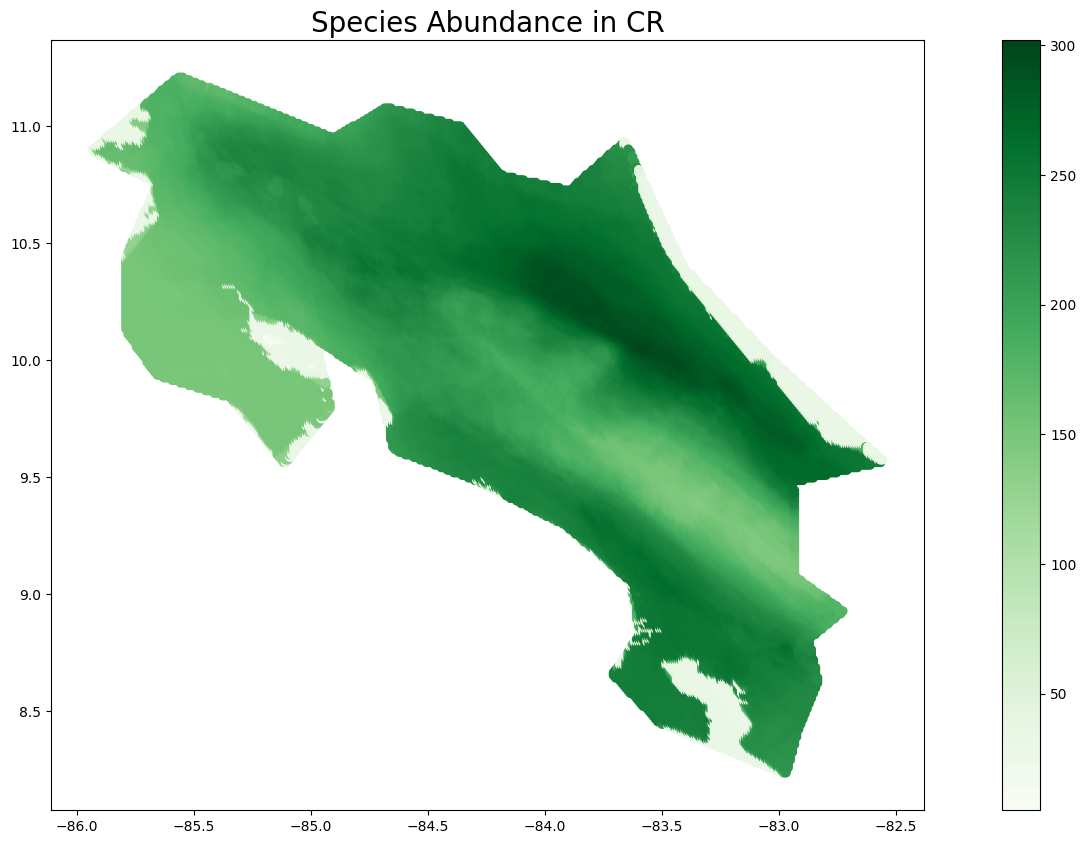

In [13]:
# get the sum of all species
final_df['species_count']=final_df.sum(axis=1)
# add the grid to the dataframe
final_df['geometry']=grid
# convert geometry to lat/lon
final_df['lon'] = final_df['geometry'].x
final_df['lat'] = final_df['geometry'].y
# plot the total species count
fig, ax = plt.subplots(figsize=(20,10))
# gpd.GeoSeries(cr_polygon).plot(ax=ax, color='white', edgecolor='black')
# plot costa rica map
cr_map=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')
cr_map.plot(ax=ax, color='white', edgecolor='black')
# use a colormap to plot the species count
final_df.plot(ax=ax, column='species_count', legend=True, cmap='Greens')
# set the title
ax.set_title('Species Abundance in CR', fontsize=20)

In [14]:
final_df

,count_amphibians,count_reptiles,count_mammals,species_count,geometry,lon,lat
0,0,8,26,34,POINT (-85.93274 10.90073),-85.932742,10.900732
1,0,6,26,32,POINT (-85.92376 10.88977),-85.923759,10.889766
2,0,8,35,43,POINT (-85.92376 10.90073),-85.923759,10.900732
3,0,6,26,32,POINT (-85.91478 10.88977),-85.914776,10.889766
4,16,15,99,130,POINT (-85.91478 10.90073),-85.914776,10.900732
...,...,...,...,...,...,...,...
45078,0,9,38,47,POINT (-82.57310 9.57385),-82.573100,9.573846
45079,0,5,29,34,POINT (-82.57310 9.58481),-82.573100,9.584812
45080,43,74,125,242,POINT (-82.56412 9.56288),-82.564117,9.562880
45081,0,6,29,35,POINT (-82.56412 9.57385),-82.564117,9.573846


In [15]:
# save the data
final_df.to_csv("species_count.csv")